## Setup and Installation


In [3]:
# Install required packages

# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_2', exist_ok=True)
os.makedirs('logs', exist_ok=True)

2025-05-13 21:06:26.156105: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 21:06:26.410394: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 21:06:26.557657: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747170386.814485   27101 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747170386.904936   27101 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747170387.355140   27101 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## 1. Data Loading and Preprocessing


In [4]:
import tensorflow_datasets as tfds

# Extract EMNIST data
def extract_data(dataset):
    images = []
    labels = []
    for image, label in dataset:
        images.append(image.numpy())  
        labels.append(label.numpy())  
    return np.array(images), np.array(labels)

def load_emnist_letters():
    dataset = tfds.load('emnist/letters', as_supervised=True)

    train_data, test_data = dataset['train'], dataset['test']

    x_train, y_train = extract_data(train_data)
    x_test, y_test = extract_data(test_data)

    # remove extra dimension for plotting
    x_train = x_train.squeeze(axis=-1) 
    x_test = x_test.squeeze(axis=-1)

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_emnist_letters()

# Print dataset information
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

2025-05-13 21:06:34.517347: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-05-13 21:06:34.654622: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-05-13 21:06:57.185407: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training data shape: (88800, 28, 28)
Test data shape: (14800, 28, 28)
Number of classes: 26


2025-05-13 21:07:01.266002: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


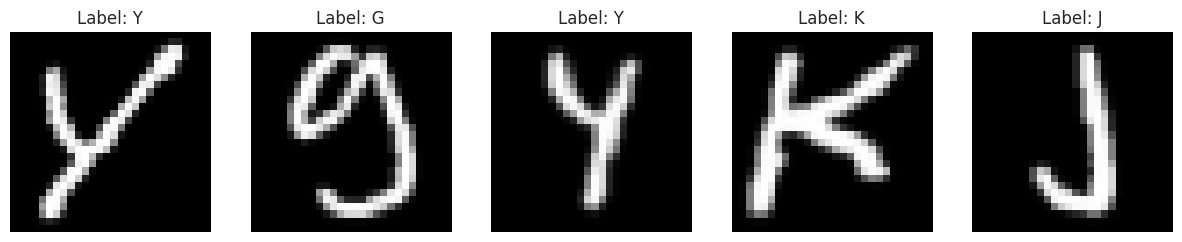

In [4]:
# Plot sample images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i].T, cmap='gray')
    plt.title(f'Label: {chr(y_train[i] + 64)}')
    plt.axis('off')
plt.show()

In [5]:
# Preprocess data

if y_train.ndim > 1:
    y_train = np.argmax(y_train, axis=-1)
if y_test.ndim > 1:
    y_test = np.argmax(y_test, axis=-1)
    
# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape for CNN layers
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)



# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train - 1, num_classes=26)
y_test = tf.keras.utils.to_categorical(y_test - 1, num_classes=26)

# Split training data into train and validation
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)


print(f"Preprocessed training data shape: {x_train.shape}")
print(f"Preprocessed validation data shape: {x_val.shape}")
print(f"Preprocessed test data shape: {x_test.shape}")

Preprocessed training data shape: (71040, 28, 28, 1)
Preprocessed validation data shape: (17760, 28, 28, 1)
Preprocessed test data shape: (14800, 28, 28, 1)


## 2. Model Implementation

### TensorFlow/Keras Implementation

In [6]:
def create_cnn_keras(input_shape, num_classes):
    """
    Create a CNN using TensorFlow/Keras.
    
    Requirements:
    - Must use at least 2 convolutional layers
    - Must include pooling and batch normalization
    - Must use categorical crossentropy loss
    
    Goals:
    - Achieve > 85% accuracy on test set
    - Minimize overfitting using batch normalization and dropout
    - Train efficiently with appropriate batch size and learning rate
    
    Args:
        input_shape: Shape of input data (should be (28, 28, 1) for grayscale images)
        num_classes: Number of output classes (26 for letters)
    
    Returns:
        Compiled Keras model
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create and compile model
keras_model = create_cnn_keras(input_shape=(28, 28, 1), num_classes=26)
keras_model.summary()

/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 227,098 (887.10 KB)

 Trainable params: 227,098 (887.10 KB)

 Non-trainable params: 0 (0.00 B)

### PyTorch Implementation


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes):
        """
        Create a CNN using PyTorch.
        
        Requirements:
        - Must use at least 2 convolutional layers
        - Must include pooling and batch normalization
        
        Goals:
        - Achieve > 85% accuracy on test set
        - Minimize overfitting using batch normalization and dropout
        - Train efficiently with appropriate batch size and learning rate
        
        Args:
            num_classes: Number of output classes (26 for letters)
        """
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        """
        Forward pass of the network.
        
        Args:
            x: Input tensor of shape (batch_size, channels, height, width)
        
        Returns:
            Output tensor of shape (batch_size, num_classes)
        """
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1)  
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Create model
py_model = CNN(num_classes=26)
print(py_model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
)


## 3. Training and Evaluation

### TensorFlow/Keras Training

y_train shape: (71040, 26)
y_train dtype: float64
Epoch 1/20


2025-05-13 21:07:23.489833: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 222781440 exceeds 10% of free system memory.


  11/2220 ━━━━━━━━━━━━━━━━━━━━ 36s 17ms/step - accuracy: 0.0643 - loss: 3.2628

2025-05-13 21:07:24.998043: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 17981568 exceeds 10% of free system memory.
2025-05-13 21:07:24.998347: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 17981568 exceeds 10% of free system memory.
2025-05-13 21:07:25.024691: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 17981568 exceeds 10% of free system memory.
2025-05-13 21:07:25.025954: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 17981568 exceeds 10% of free system memory.


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.6072 - loss: 1.3030 - val_accuracy: 0.8889 - val_loss: 0.3453 - learning_rate: 0.0010
Epoch 2/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - accuracy: 0.8427 - loss: 0.4904 - val_accuracy: 0.9154 - val_loss: 0.2613 - learning_rate: 0.0010
Epoch 3/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.8735 - loss: 0.3859 - val_accuracy: 0.9237 - val_loss: 0.2286 - learning_rate: 0.0010
Epoch 4/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.8895 - loss: 0.3351 - val_accuracy: 0.9269 - val_loss: 0.2196 - learning_rate: 0.0010
Epoch 5/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 39s 17ms/step - accuracy: 0.9021 - loss: 0.2922 - val_accuracy: 0.9298 - val_loss: 0.2120 - learning_rate: 0.0010
Epoch 6/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.9095 - loss: 0.2677 - val_accuracy: 0.9332 - val_loss: 0.2043 - learning_rate: 0.0010
Epoch 7/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step - accuracy: 0.9135 

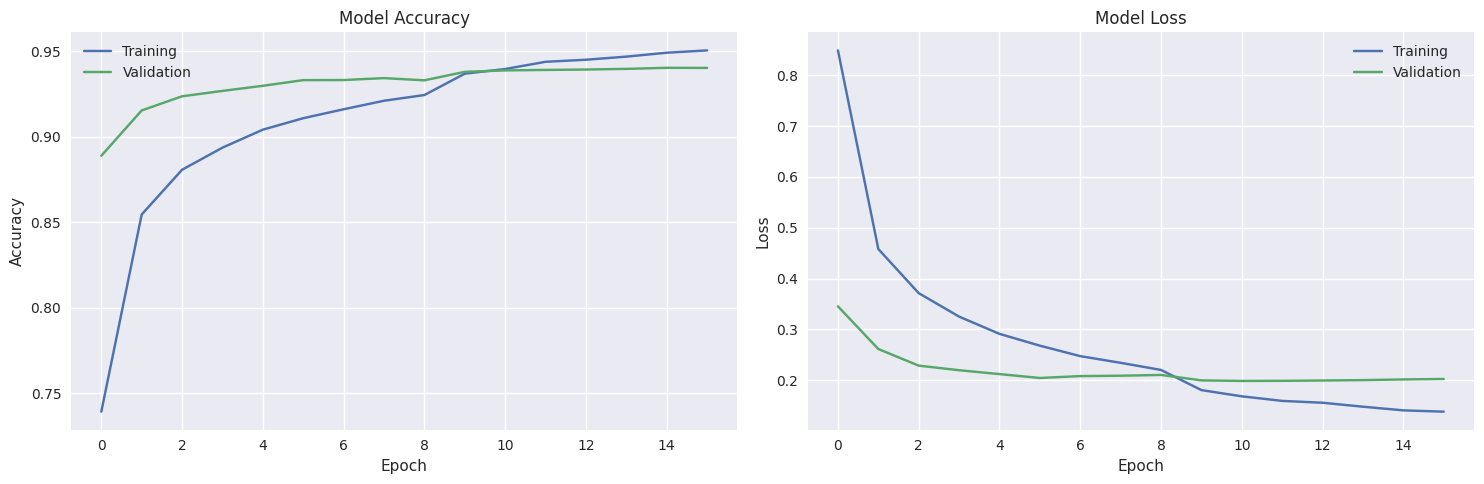

In [7]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/cnn_keras.keras',
        save_best_only=True
    )
]
print(f"y_train shape: {y_train.shape}")
print(f"y_train dtype: {y_train.dtype}")


# Train model
history = keras_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

### PyTorch Training

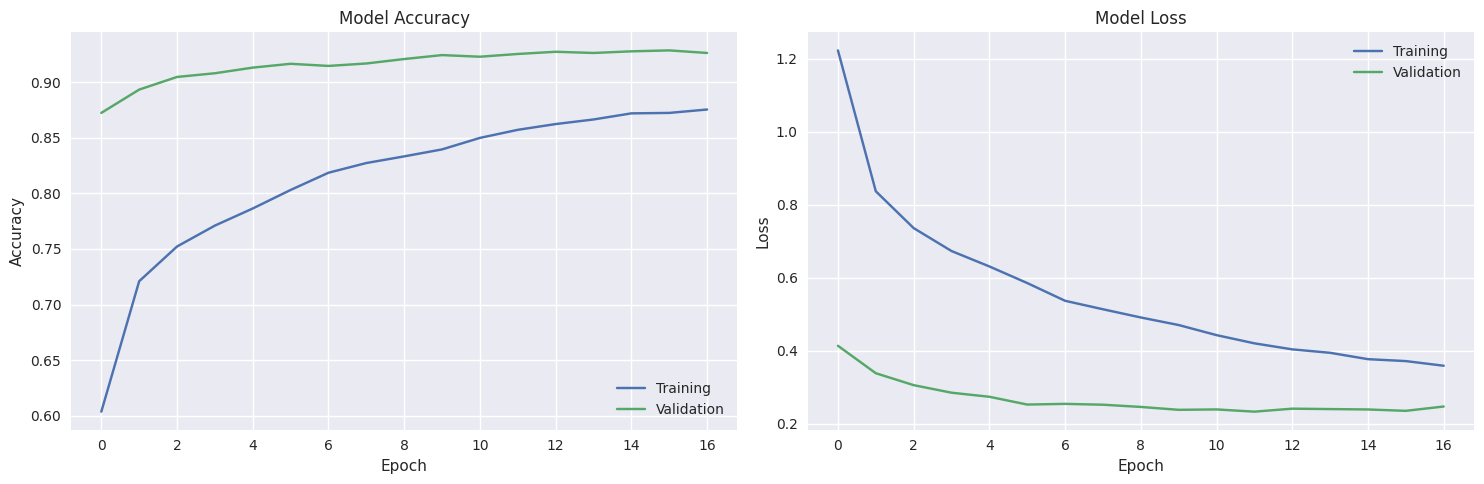

In [13]:
# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = py_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Convert data to PyTorch tensors
x_train = torch.FloatTensor(x_train).to(device)
x_val = torch.FloatTensor(x_val).to(device)

# Check if labels are one-hot encoded (e.g., with shape (N, 26))
# If they are, convert to class indices using np.argmax
y_train = torch.LongTensor(np.argmax(y_train, axis=1)).to(device) if y_train.ndim > 1 else torch.LongTensor(y_train).to(device)
y_val = torch.LongTensor(np.argmax(y_val, axis=1)).to(device) if y_val.ndim > 1 else torch.LongTensor(y_val).to(device)

# Ensure the shape is (batch_size, channels, height, width)
x_train = x_train.permute(0, 3, 1, 2)  # Convert from (batch_size, height, width, channels) to (batch_size, channels, height, width)
x_val = x_val.permute(0, 3, 1, 2)  # Do the same for validation data

# Training loop
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(20):
    # Training
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for i in range(0, len(x_train), 32):
        batch_x = x_train[i:i+32]
        batch_y = y_train[i:i+32]
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += batch_y.size(0)
        train_correct += predicted.eq(batch_y).sum().item()
    
    train_loss = train_loss / (len(x_train) / 32)
    train_acc = train_correct / train_total
    
    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for i in range(0, len(x_val), 32):
            batch_x = x_val[i:i+32]
            batch_y = y_val[i:i+32]
            
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += batch_y.size(0)
            val_correct += predicted.eq(batch_y).sum().item()
    
    val_loss = val_loss / (len(x_val) / 32)
    val_acc = val_correct / val_total
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'models/cnn_pytorch.pt')
        # Save architecture
        with open('models/cnn_pytorch_arch.txt', 'w') as f:
            f.write(str(model))
    else:
        patience_counter += 1
        if patience_counter >= patience:
            break

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history['train_acc'], label='Training')
ax1.plot(history['val_acc'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history['train_loss'], label='Training')
ax2.plot(history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

463/463 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9280 - loss: 0.2235
Test accuracy: 0.9291
463/463 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


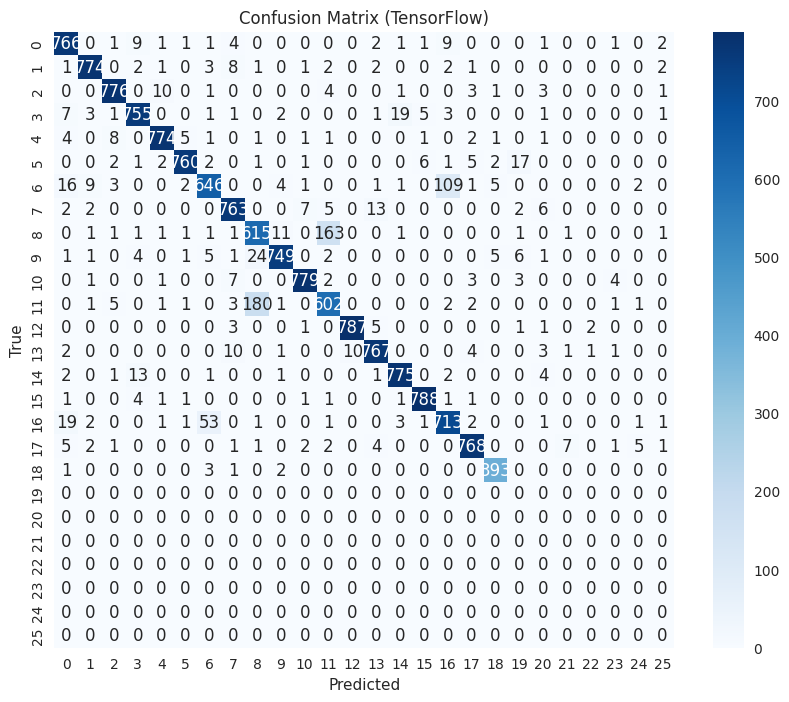

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluate model
test_loss, test_accuracy = keras_model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Get predictions
predictions = keras_model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Confusion matrix
cm = tf.math.confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (TensorFlow)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate metrics
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

# Save metrics
os.makedirs('results/part_2', exist_ok=True)
with open('results/part_2/cnn_tensorflow_metrics.txt', 'w') as f:
    f.write("model: cnn_tensorflow\n")
    f.write(f"accuracy: {test_accuracy:.4f}\n")
    f.write(f"precision: {precision:.4f}\n")
    f.write(f"recall: {recall:.4f}\n")
    f.write(f"f1_score: {f1:.4f}\n")
    f.write(f"confusion_matrix: {cm.numpy().tolist()}\n")


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


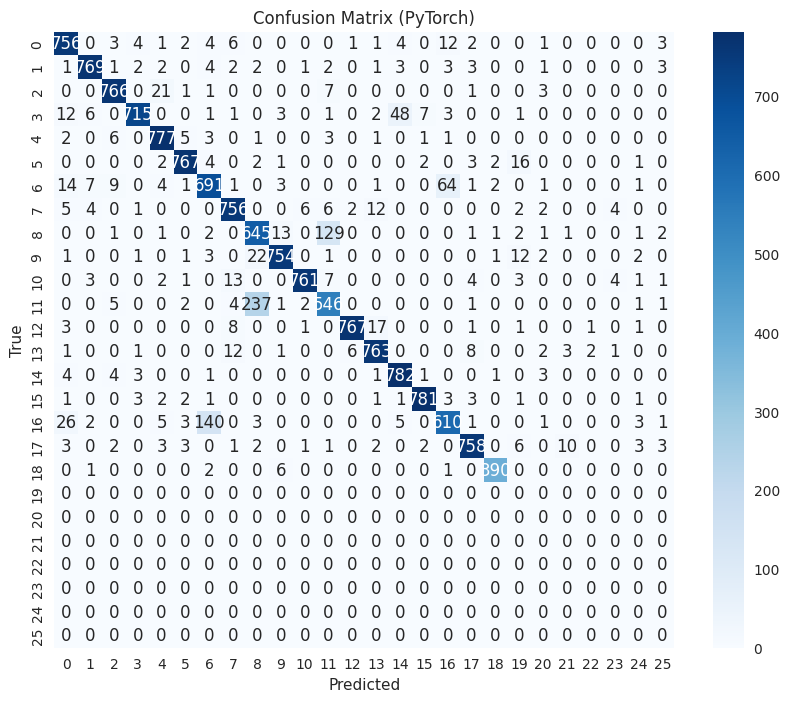

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Ensure test data is shaped correctly
x_test_tensor = torch.FloatTensor(x_test).permute(0, 3, 1, 2).to(device)
y_test_tensor = torch.LongTensor(np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test).to(device)

# Evaluate on test data
py_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for i in range(0, len(x_test_tensor), 32):
        batch_x = x_test_tensor[i:i+32]
        batch_y = y_test_tensor[i:i+32]
        outputs = model(batch_x)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# Calculate metrics
test_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
cm = tf.math.confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (PyTorch)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save metrics
os.makedirs('results/part_2', exist_ok=True)
with open('results/part_2/cnn_pytorch_metrics.txt', 'w') as f:
    f.write("model: cnn_pytorch\n")
    f.write(f"accuracy: {test_accuracy:.4f}\n")
    f.write(f"precision: {precision:.4f}\n")
    f.write(f"recall: {recall:.4f}\n")
    f.write(f"f1_score: {f1:.4f}\n")
    f.write(f"confusion_matrix: {cm.numpy().tolist()}\n")
